##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install pandas 
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install numpy
%pip install sklearn.neural_network
%pip install sklearn.model_selection
%pip install sklearn.metrics
%pip install collections
%pip install imblearn.over_sampling
%pip install joblib

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [2]:
###...code...###

df = pd.read_parquet(filepath)

In [4]:
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Data Analysis

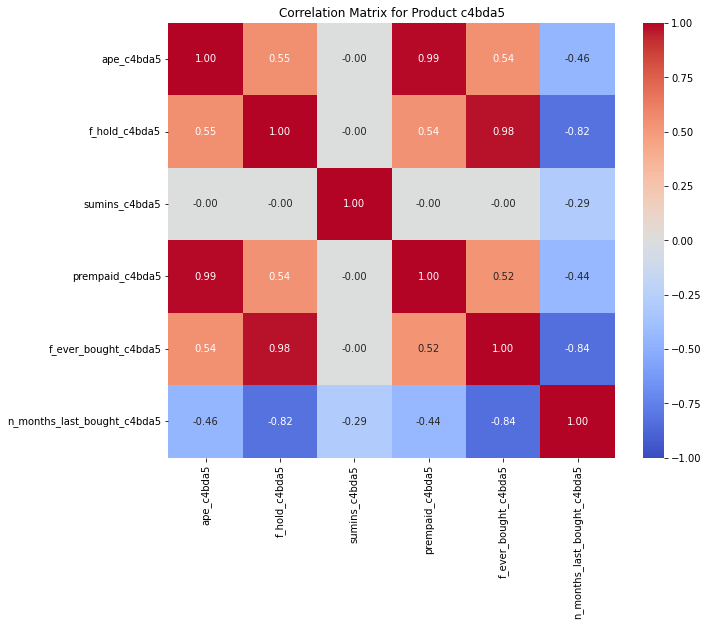

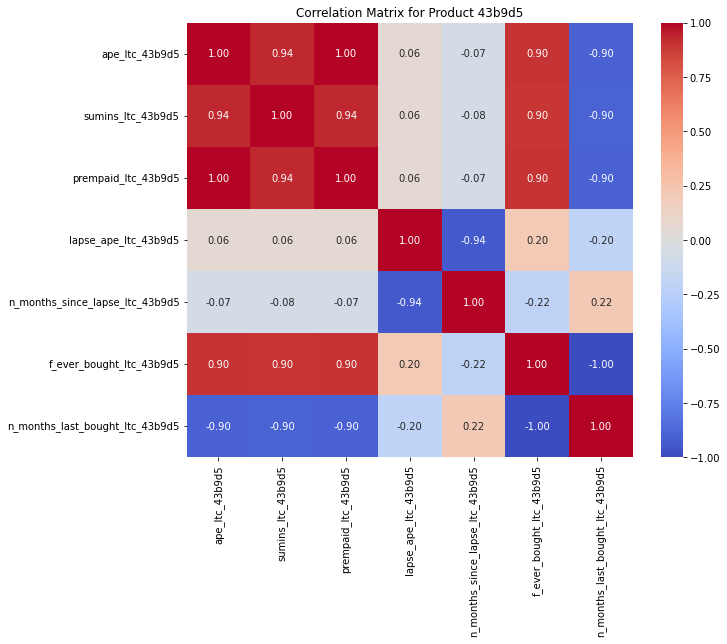

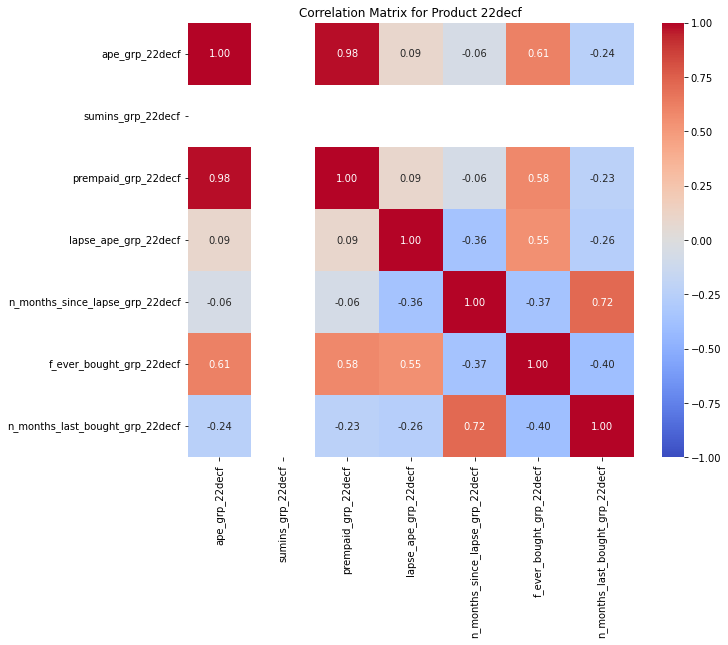

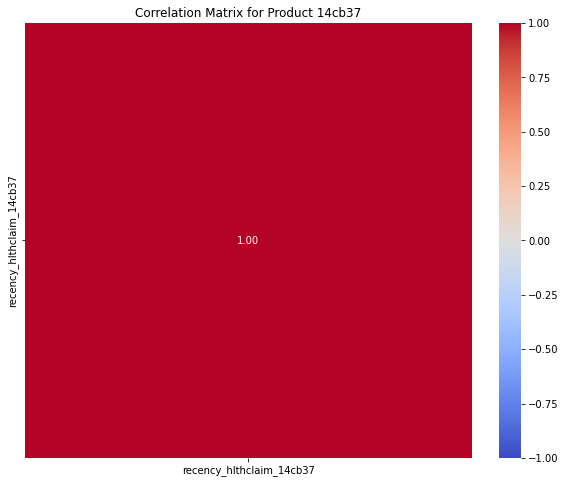

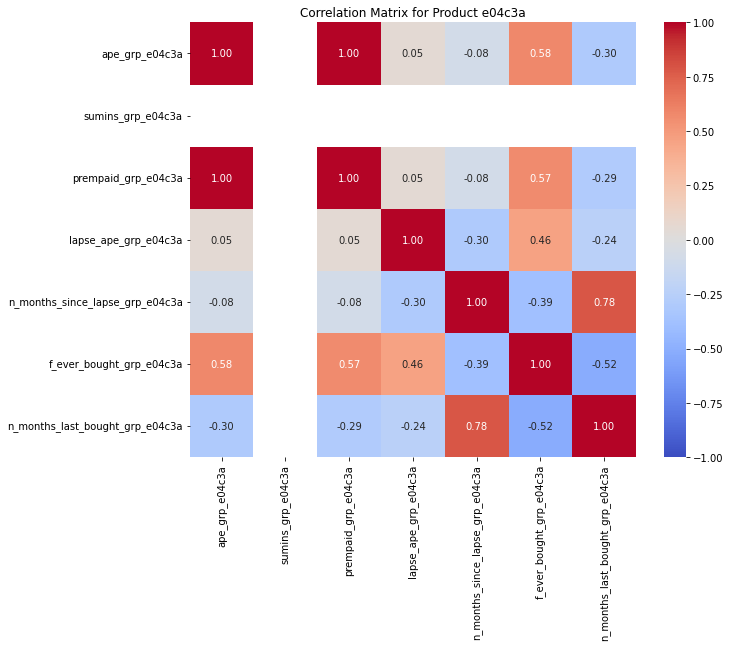

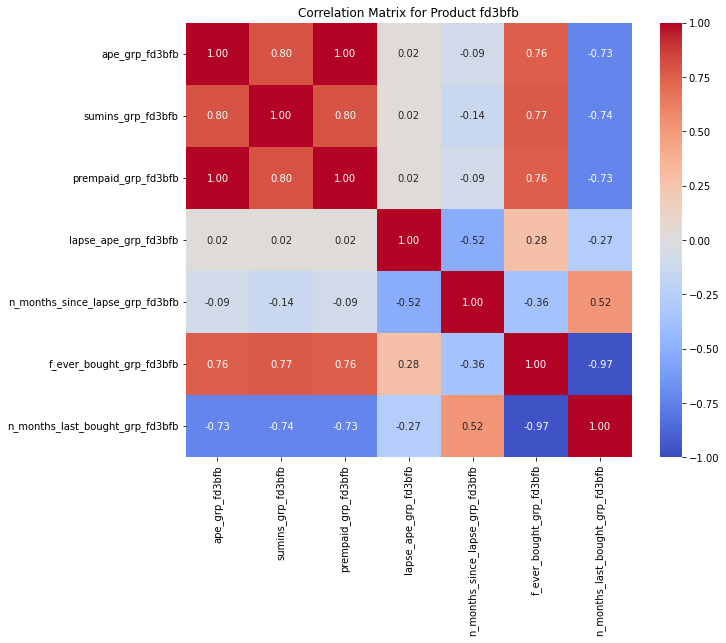

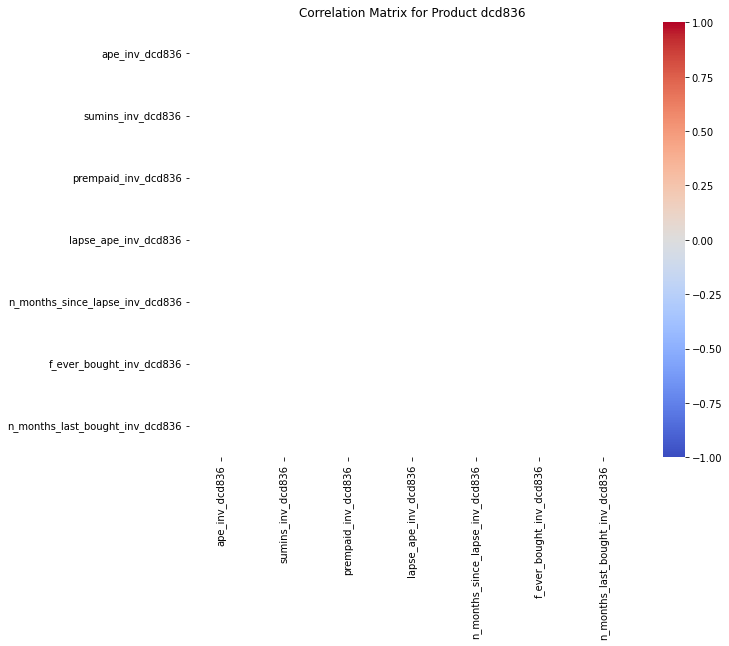

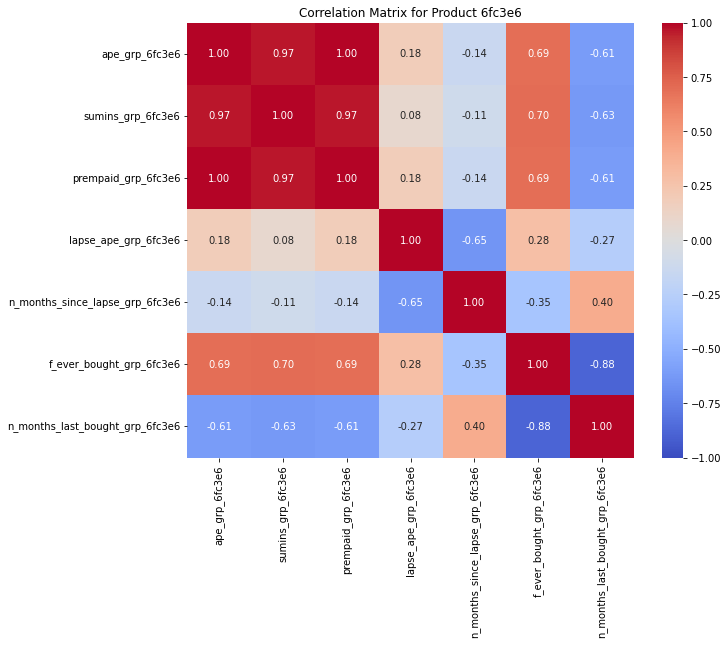

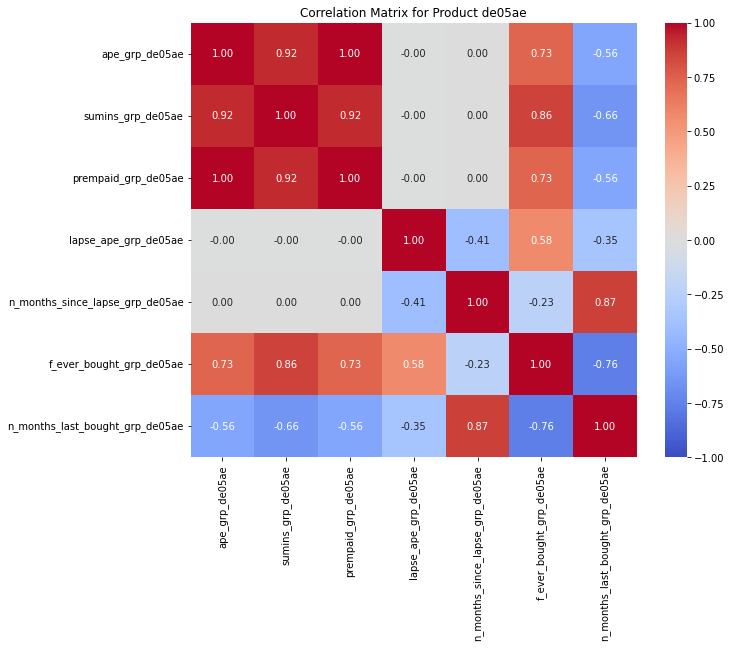

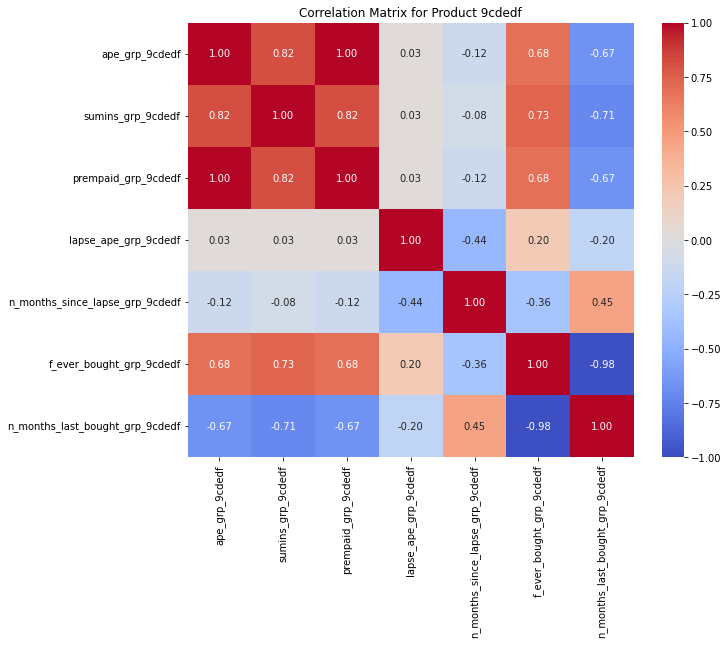

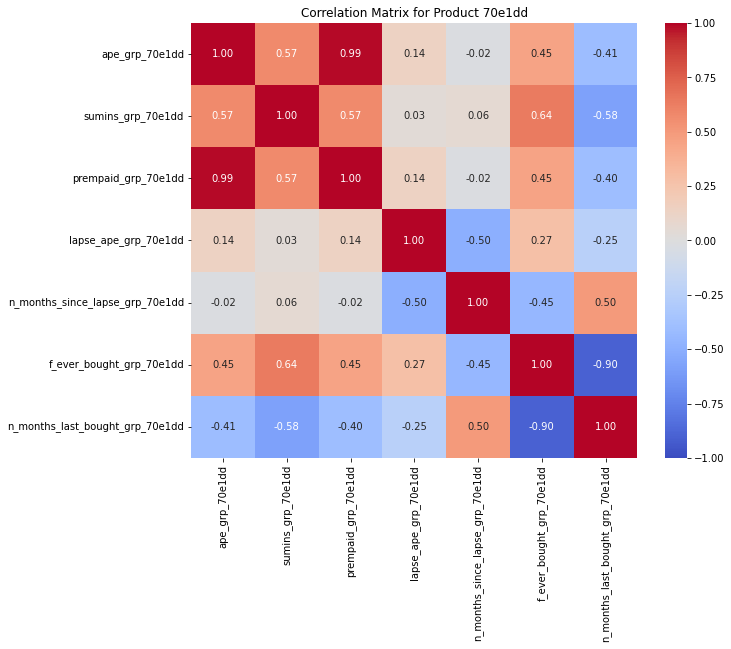

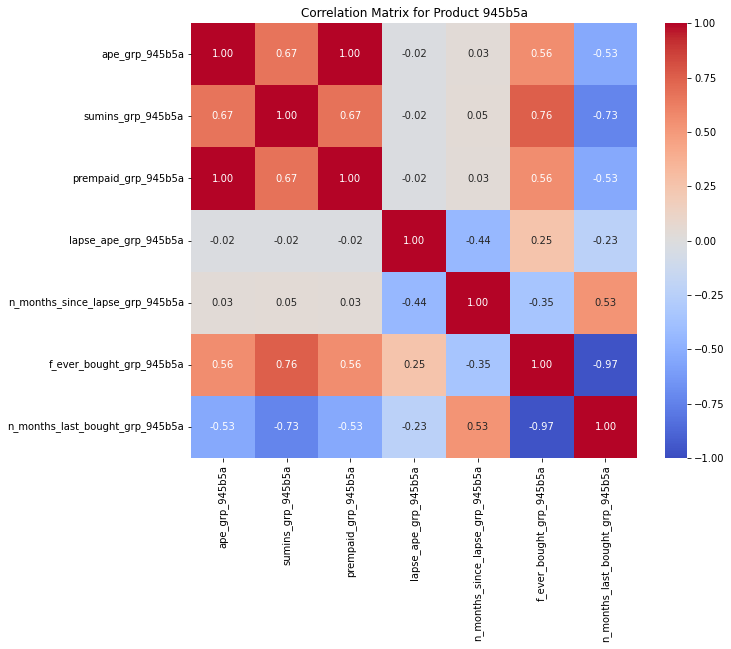

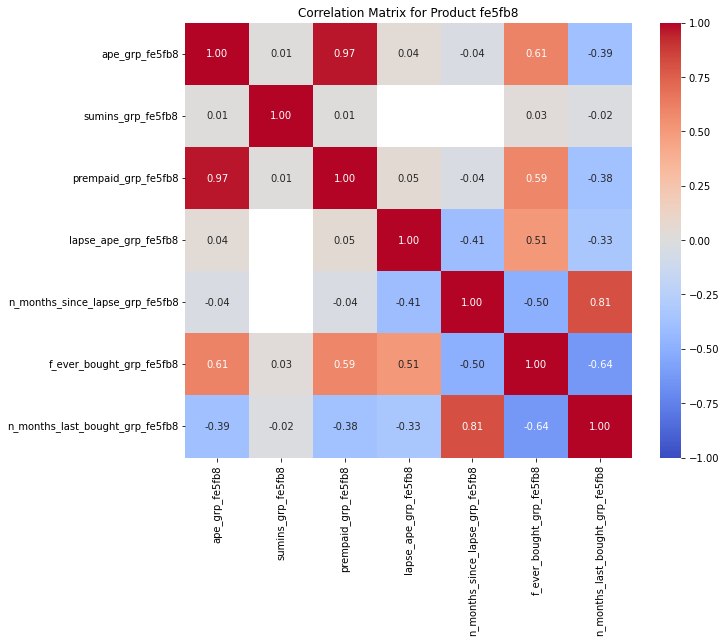

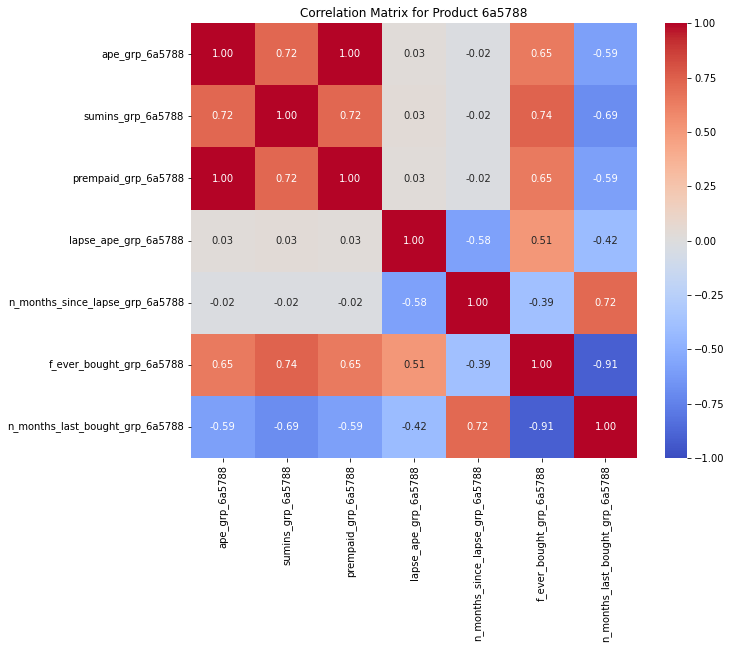

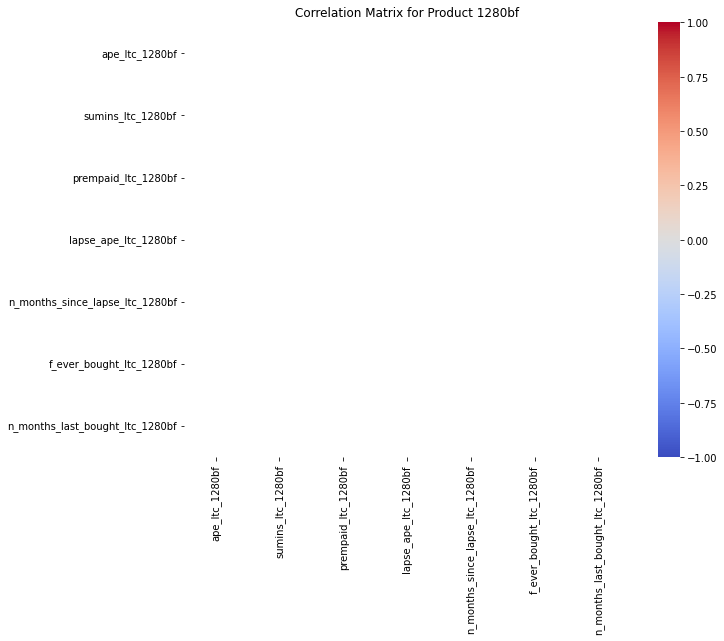

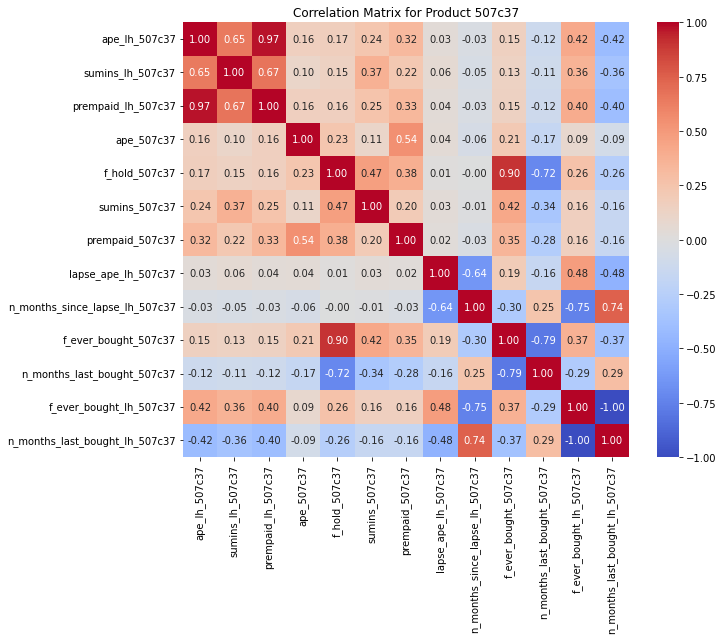

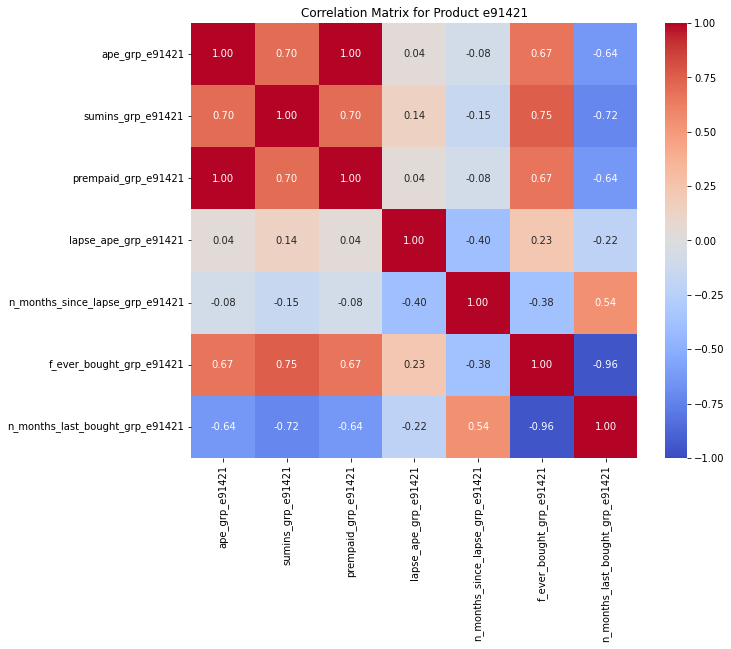

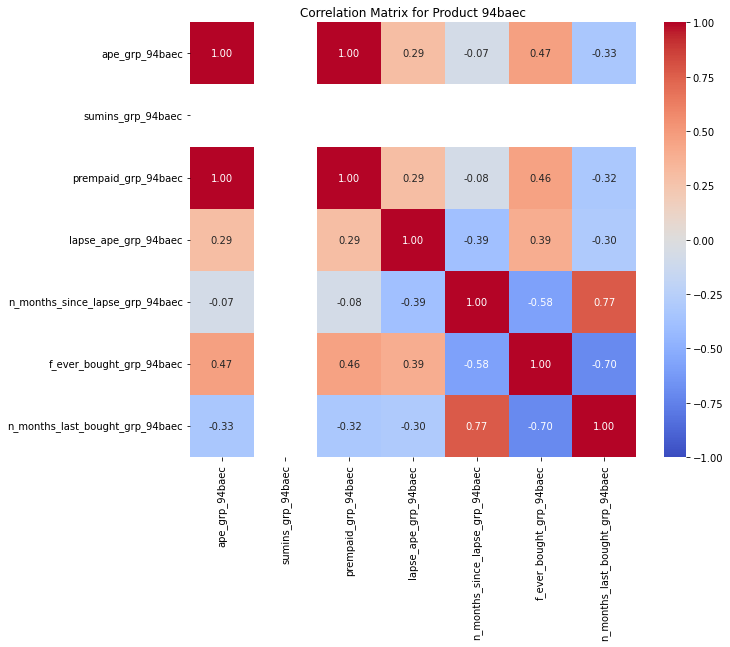

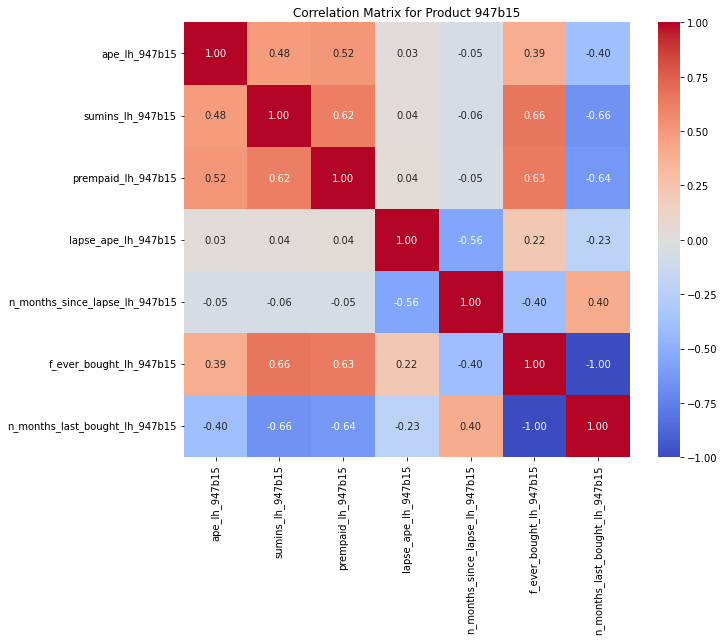

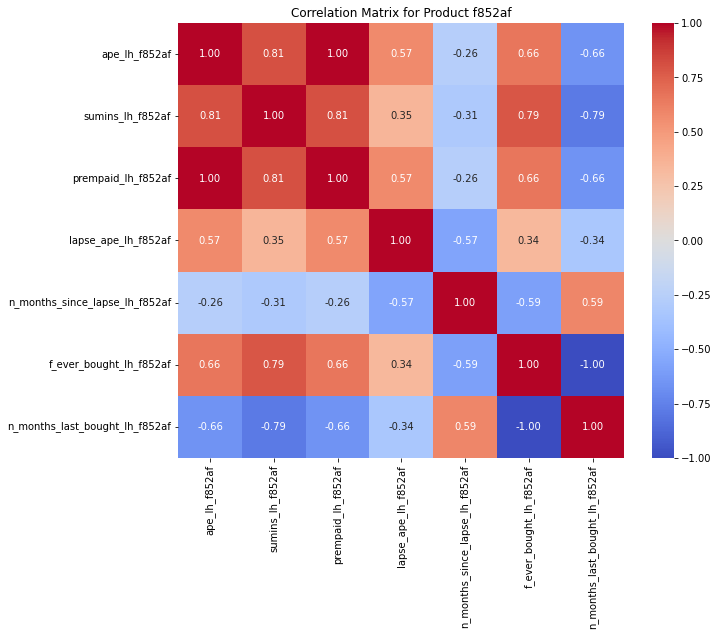

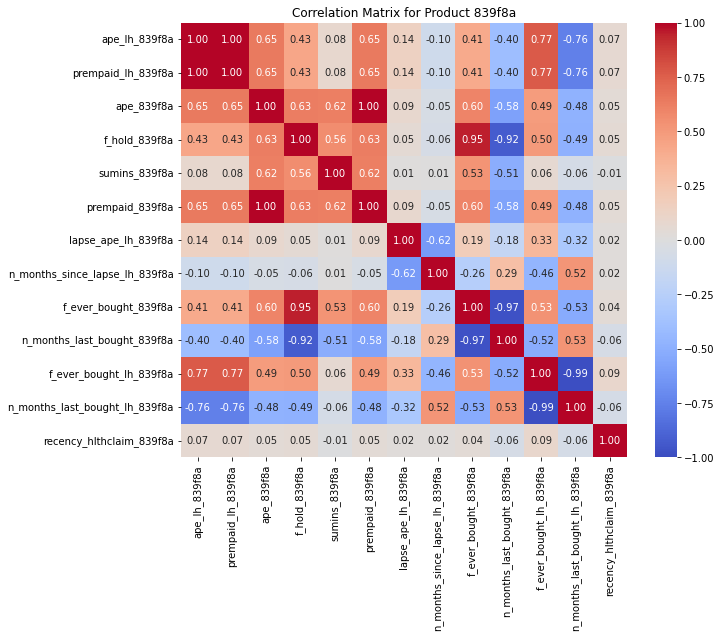

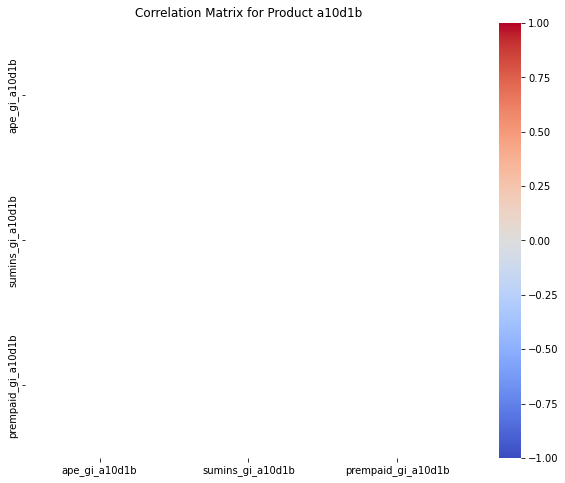

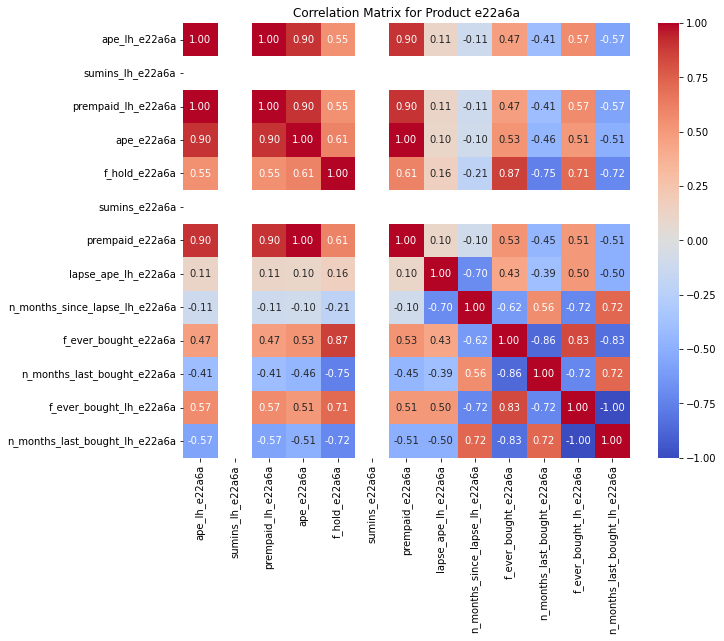

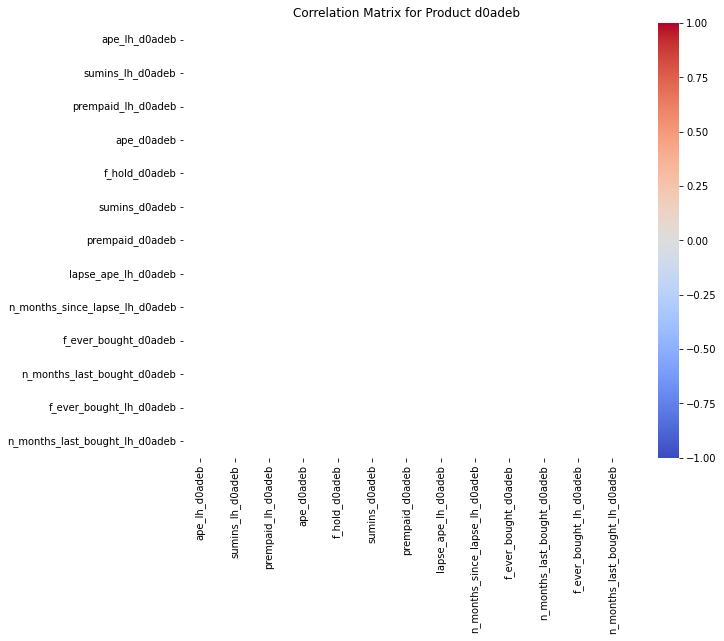

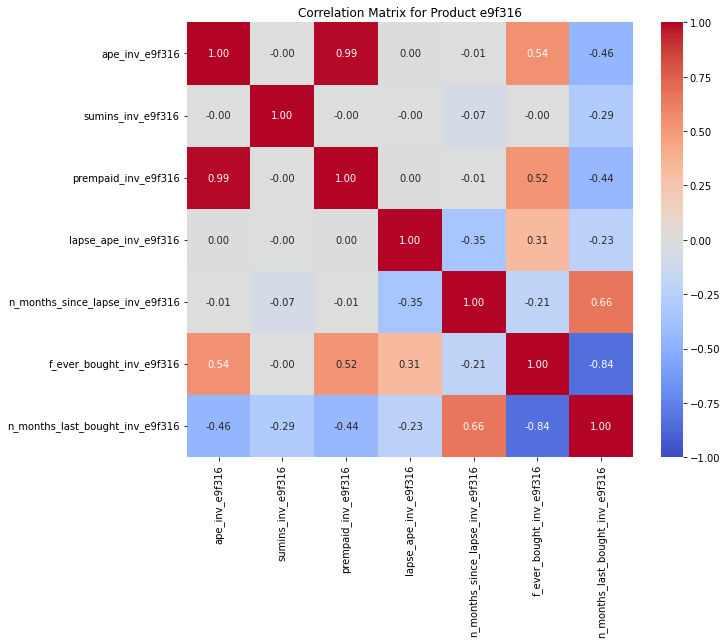

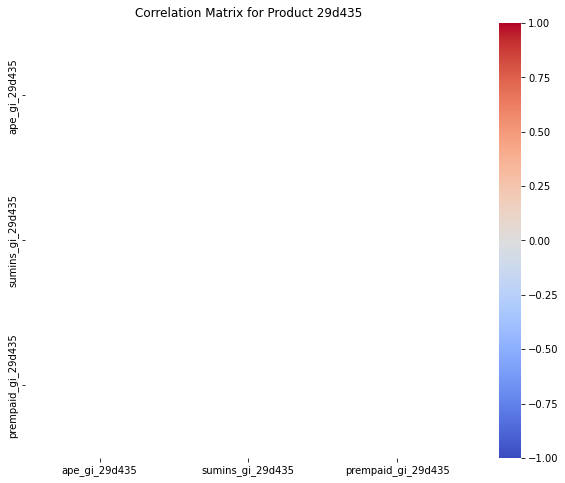

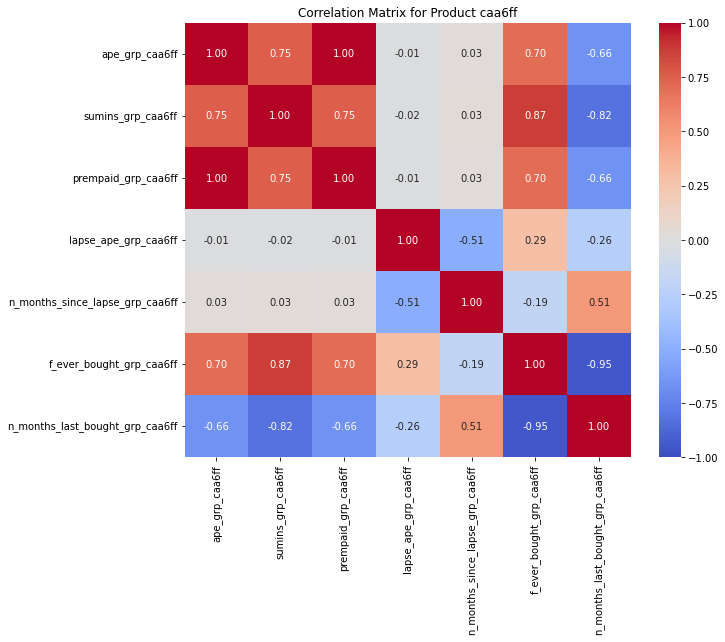

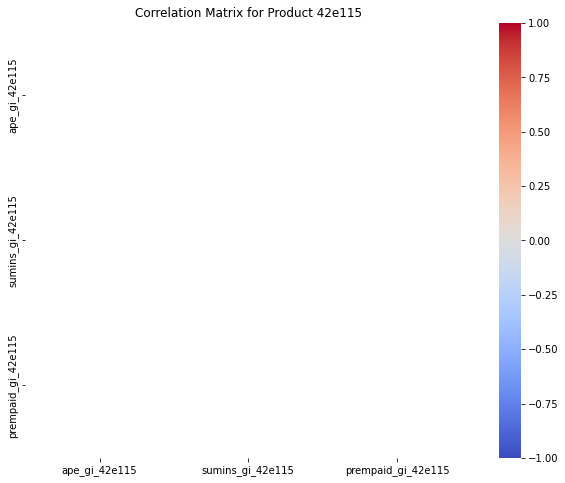

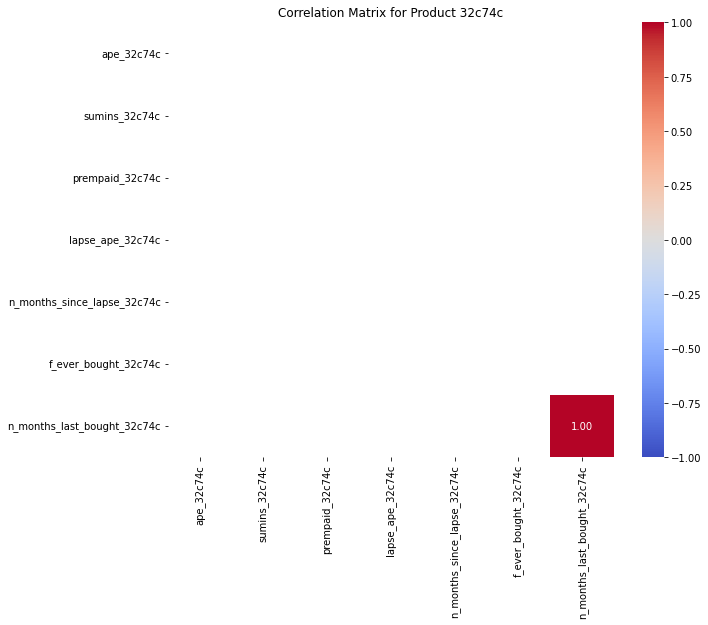

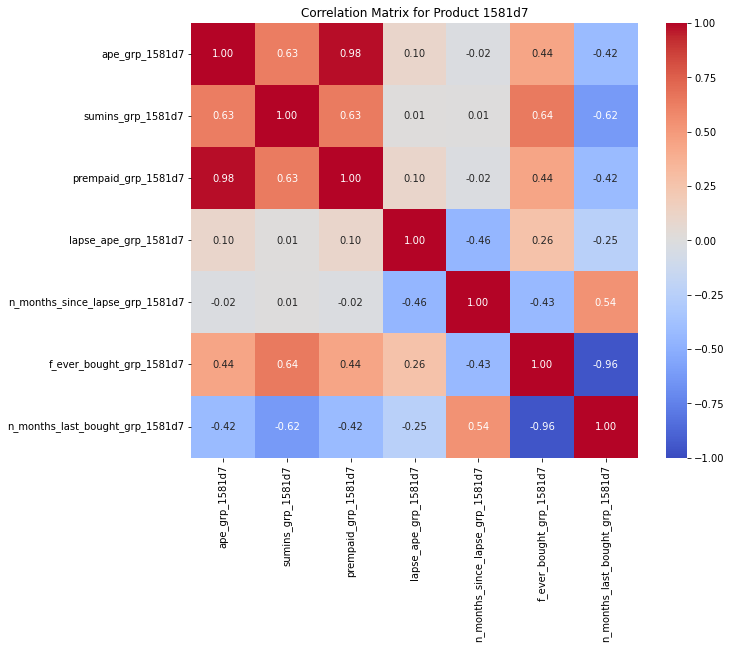

In [5]:
product_ids = set(col.split('_')[-1] for col in df.columns)
filtered_product_ids = [product_id for product_id in product_ids if any(char.isalpha() for char in product_id) and any(char.isdigit() for char in product_id)]

for product_id in filtered_product_ids:
    # Select columns for the current product ID
    product_cols = [col for col in df.columns if col.endswith(f'_{product_id}')]

    # Create a subset DataFrame with columns for the current product ID
    product_df = df[product_cols]

    # Calculate correlation matrix
    corr_matrix = product_df.corr()

    # Plot correlation matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Product {product_id}')
    plt.show()

In [6]:
income_mapping = {'E.BELOW30K': 0,
           'D.30K-60K': 1,
           'C.60K-100K': 2,
           'B.100K-200K': 3,
           'A.ABOVE200K': 4}
df['annual_income_est'] = df['annual_income_est'].map(income_mapping)

In [7]:
hh_est_mapping = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '>4' : 5
}
df['hh_size_est'] = df['hh_size_est'].map(hh_est_mapping)

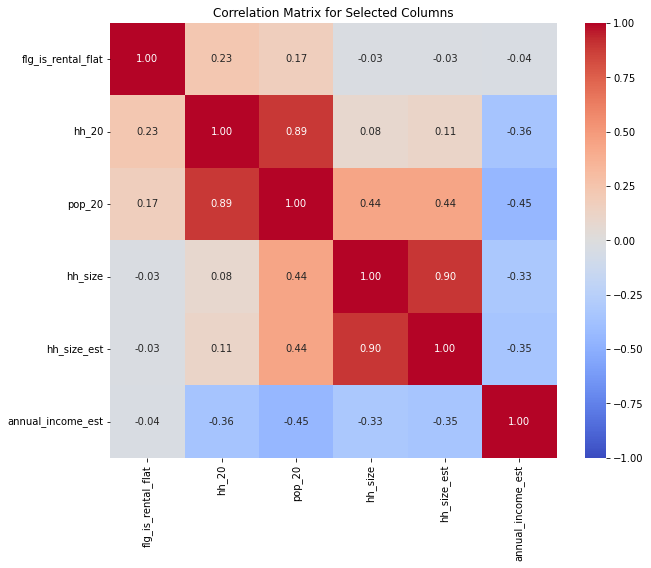

In [8]:
# check correlation for columns on household, population, and income
selected_columns = ["flg_is_rental_flat","hh_20", "pop_20", "hh_size", "hh_size_est", "annual_income_est"]
selected_df = df[selected_columns]

# Calculate correlation matrix
corr_matrix = selected_df.corr()

# Plot correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Columns')
plt.show()

In [9]:
# Generating the correlation matrix containing word x in the columns
def generate_corr_matrix(df, word):
    # Select columns containing the word
    word_cols = [col for col in df.columns if word in col]

    # Create a subset DataFrame with columns containing the word
    word_df = df[word_cols]

    # Calculate correlation matrix
    corr_matrix = word_df.corr()

    # Plot correlation matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Columns Containing {word}')
    plt.show()

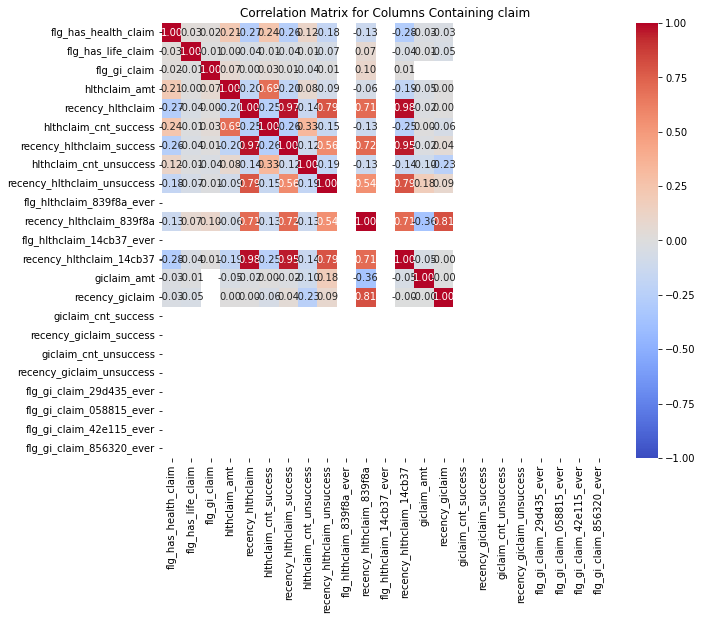

In [10]:
generate_corr_matrix(df, 'claim')

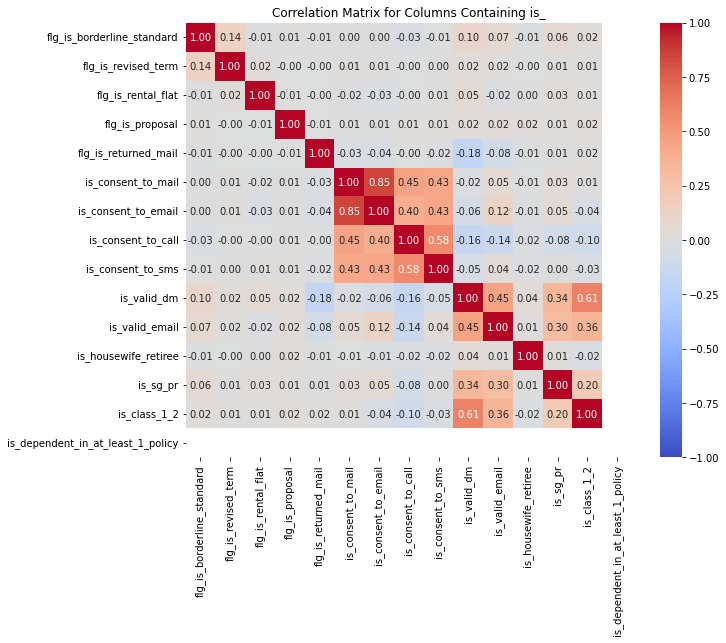

In [11]:
generate_corr_matrix(df, 'is_')

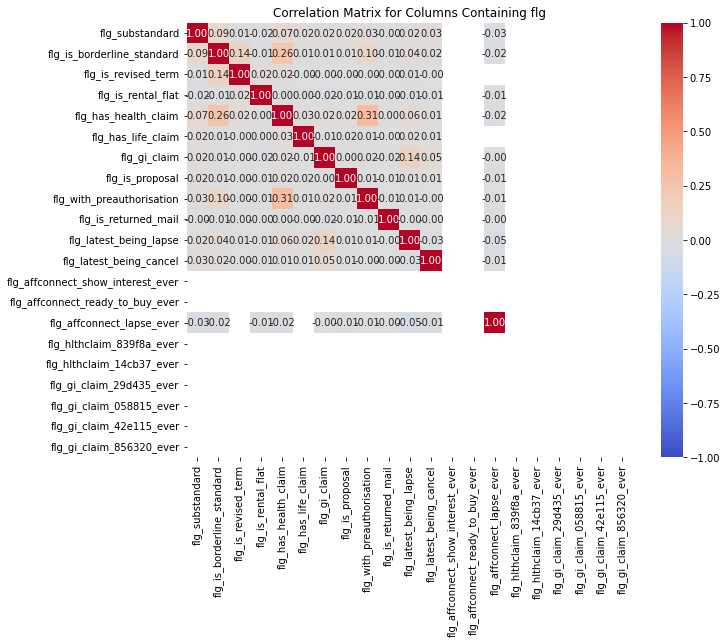

In [12]:
generate_corr_matrix(df, 'flg')

# Model Training

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [15]:
"""IMPORT STATEMENTS HERE"""

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import joblib



def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''

    # Convert NAs in columns with x to 0s
    def fillna_with_0(df, x):
        x_cols = [col for col in df.columns if x in col]
        df[x_cols] = df[x_cols].fillna(0)


    df = hidden_data

    # Drop the columns with only one value (constant columns)
    df = df.loc[:, df.apply(lambda x: x.nunique(dropna=False) > 1)]

    # For the columns with only 1s and NAs, fill the NAs with 0s
    df = df.apply(lambda col: col.fillna(0) if col.nunique() == 1 and 1 in col.values else col, axis=0)

    # From the above correlation matrices, can see that prempaid and ape are highly correlated with each other.
    # Drop the columns with prempaid
    df = df.drop(df.filter(like='prempaid', axis=1).columns, axis=1)

    # From the above correlation matrices, can see that f_ever_bought_ape and n_months_last_bought are highly correlated with each other.
    # Drop the columns with f_ever_bought_
    df = df.drop(df.filter(like='f_ever_bought_', axis=1).columns, axis=1)

    # obtaining customers age, imputing NA using median, then removing the column cltdob_fix
    df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'], errors='coerce', format='%Y-%m-%d')
    df['age'] = datetime.now().year - df['cltdob_fix'].dt.year
    median_age = df['age'].median()
    df['age'] = df['age'].fillna(median_age)
    df = df.drop(columns=['cltdob_fix'])

    # convert min_occ_date to yr
    df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], errors='coerce', format='%Y-%m-%d')
    df['min_occ_date'] = datetime.now().year - df['min_occ_date'].dt.year

    income_mapping = {'E.BELOW30K': 0,
           'D.30K-60K': 1,
           'C.60K-100K': 2,
           'B.100K-200K': 3,
           'A.ABOVE200K': 4}
    df['annual_income_est'] = df['annual_income_est'].map(income_mapping)

    hh_est_mapping = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '>4' : 5
    }
    df['hh_size_est'] = df['hh_size_est'].map(hh_est_mapping)

    df = df.drop(columns=['pop_20', 'hh_size_est'])

    # Keep recency_hlthclaim and drop correlated columns
    df = df.drop(columns=['recency_hlthclaim_839f8a', 'recency_hlthclaim_unsuccess', 'recency_hlthclaim_success'])

    # converting the ctrycode_desc to binary, “Singapore” (1)  or “Not Singapore” (0)
    df['ctrycode_desc'] = df['ctrycode_desc'].apply(lambda x: 1 if x == 'Singapore' else 0)

    df = df.drop(columns=['is_consent_to_email'])

    # Dropping columns for lapse with entries either 0/9999 and NAs except 'is_dependent_in_at_least_1_policy'
    df['is_dependent_in_at_least_1_policy'].fillna(1, inplace=True)
    df = df.loc[:, df.nunique(dropna=True) > 1]

    fillna_with_0(df, 'amt')

    fillna_with_0(df, 'lapse_ape')
    df['recency_lapse'].fillna(0, inplace=True)

    fillna_with_0(df, 'success')

    # Convert NAs in 'n_months_since' columns to 9999
    n_months_since_cols = [col for col in df.columns if 'n_months_since' in col]
    df[n_months_since_cols] = df[n_months_since_cols].fillna(9999)

    fillna_with_0(df, 'flg')

    # Convert NAs in 'is_sg_pr' columns to 1
    # Assumption: majority are flagged as 1 & 'cntrycode_desc' is mostly Singapore
    df['is_sg_pr'].fillna(1, inplace=True)

    fillna_with_0(df, 'is_')
    fillna_with_0(df, 'visit')

    # cases where 'recency_clmcon' & 'recency_clmcon_regis' having NA values are marked
    # as 'clmcon_visit_days' = 0
    fillna_with_0(df, 'recency_clmcon')

    df['tot_cancel_pols'].fillna(0, inplace=True)

    # Add extra column to denote NAs
    columns = ['annual_income_est', 'recency_cancel', 'recency_hlthclaim', 'recency_hlthclaim_14cb37', 'recency_giclaim']
    for column in columns:
        df[f'{column}_is_na'] = df[column].isna().astype(int)
    df[columns] = df[columns].fillna(0)

    # Apply one-hot encoding to categorical column 'cltsex_fix'
    # NAs will simply have 0s for both columns
    df['cltsex_f'] = np.where(df['cltsex_fix'] == 'Female', 1, 0)
    df['cltsex_m'] = np.where(df['cltsex_fix'] == 'Male', 1, 0)
    df.drop(columns=['cltsex_fix'], inplace=True)

    # Apply one-hot encoding to categorical column 'race_desc'
    # NAs will simply have 0s for all the columns
    df['race_desc_Chinese'] = np.where(df['race_desc'] == 'Chinese', 1, 0)
    df['race_desc_Others'] = np.where(df['race_desc'] == 'Others', 1, 0)
    df['race_desc_Indian'] = np.where(df['race_desc'] == 'Indian', 1, 0)
    df['race_desc_Malay'] = np.where(df['race_desc'] == 'Malay', 1, 0)
    df.drop(columns=['race_desc'], inplace=True)

    # Apply one-hot encoding to categorical column 'clttype'
    # 'C' will simply have 0s for all the columns
    df['clttype_P'] = np.where(df['clttype'] == 'P', 1, 0)
    df['clttype_G'] = np.where(df['clttype'] == 'G', 1, 0)
    df.drop(columns=['clttype'], inplace=True)

    # Apply one-hot encoding to categorical column 'stat_flag'
    # 'MATURED' will simply have 0s for all the columns
    df['stat_flag_A'] = np.where(df['stat_flag'] == 'ACTIVE', 1, 0)
    df['stat_flag_L'] = np.where(df['stat_flag'] == 'LAPSED', 1, 0)
    df.drop(columns=['stat_flag'], inplace=True)

    df['min_occ_date'].fillna(0, inplace=True)

    df['hh_na'] = df['hh_size'].isna().astype(int)
    df['hh_size'].fillna(0, inplace=True)
    df['hh_20'].fillna(0, inplace=True)
    df.drop(columns=['clntnum'], inplace=True)

    """LOAD MODEL"""
    model = joblib.load('rfmodel.joblib')

    result = model.predict(df)
    return result

##### Cell to check testing_hidden_data function

In [18]:
# This cell should output a list of predictions.
import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[1. 0. 0. ... 0. 0. 0.]
17992


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!